## About this notebook

Most of the data and code needed to recreate the figures is included in this repository. The starting point for the analysis is considered to be the data set of drug-county (and drug-state) deviances.  Ideally, the starting point would be the patient data from MarketScan, but that data is proprietary (as well as large).

This notebook allows recreation of all the figures from the starting point of the analysis. The exception is Figure 1A, which requires another file.  The only figures not made in python were made in [Circos](http://circos.ca/). This notebook creates the input files for Circos, and the configuration file used is included in the github repo.

## Setting up the data and environement

The lines below import most of the data, and run the PCA analysis using the code in the `code` directory.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

(c2d, partition2drug) = pickle.load(open('data/c2d_partition2drug.pkl'))
demo0 = pd.read_pickle('data/demo_deredundanted.pkl')
dev = pd.read_pickle('data/drug_county_deviance_ctynorm.pkl')
fda_nadac = pd.read_pickle('data/fda_nadac_prices_units.pkl')

sys.path.append('code')
import pca
import figures
import maps
import clustimg
m, emp = maps.load_maps()

In [27]:
pcav, U, Sigma, VT = pca.svd_correlations(dev, demo0, fda_nadac, partition2drug)

## Figure 1

### Figure 1A
Unfortunately the file `mergeRxUSA.pkl` is a bit too large for github, but it can be provided on request. Figure 1A cannot be reproduced without this file. The first few entries are shown to give an idea of what is in it.  

In [50]:
mod = pd.read_pickle('data/mergeRxUSA.pkl')
modc = figures.make_compress(mod, np.array(range(1,11) + [15,20]  ), 'visits')
modc.iloc[:5,:5]

fluticasone_furoate  neomycin_sulfate  \
year age visits nbin type                                           
2    0   1      1    count                  0.0               0.0   
                     denom               6955.0            6955.0   
                2    count                  0.0               0.0   
                     denom               3839.0            3839.0   
                3    count                  0.0               0.0   

                            betamethasone_dipropionate_calcipotriene  \
year age visits nbin type                                              
2    0   1      1    count                                       0.0   
                     denom                                    6955.0   
                2    count                                       0.0   
                     denom                                    3839.0   
                3    count                                       0.0   

                            amcinonide  oxybutynin  
year age visits nbin type                           
2    0   1      1    count         0.0         0.0  
                     denom      6955.0      6955.0  
                2    count         0.0         0.0  
                     denom      3839.0      3839.0  
                3    count         0.0         0.0

In [51]:
modc.shape

(26572, 1103)

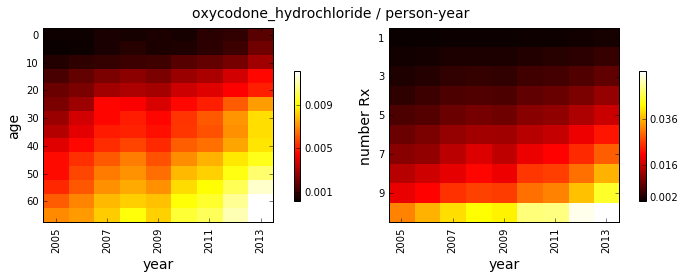

In [44]:

f = figures.drug_trend_images(modc, 'oxycodone_hydrochloride', {'age':{},
        'visits':{}})  

### Figure 1B

0


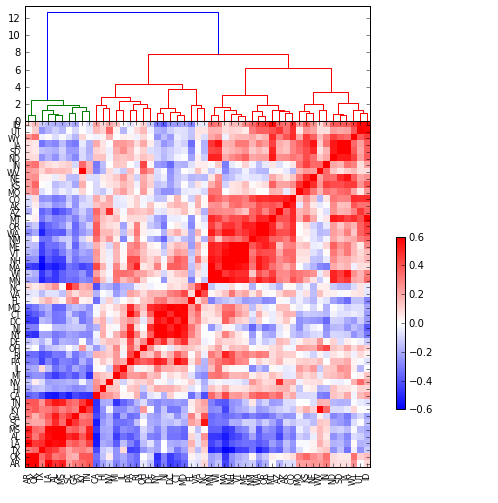

In [46]:
ds = pd.read_pickle('data/drugXstate.predreg.pkl')
ds = ds/np.std(ds)
stid2name = pickle.load(open('data/stateid2statename.pkl'))
st_correlations = pd.DataFrame(np.corrcoef(ds.transpose()),index=ds.columns, columns=ds.columns)
clusout = clustimg.clust2way(st_correlations.rename(index=stid2name, columns=stid2name),
                           'bwr',
                               cmax=.6,cmin=-.6,no_row_dendrogram=True, hide_top_axis=False)

states? True


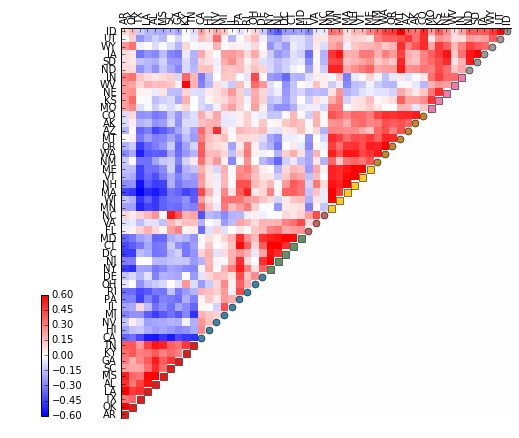

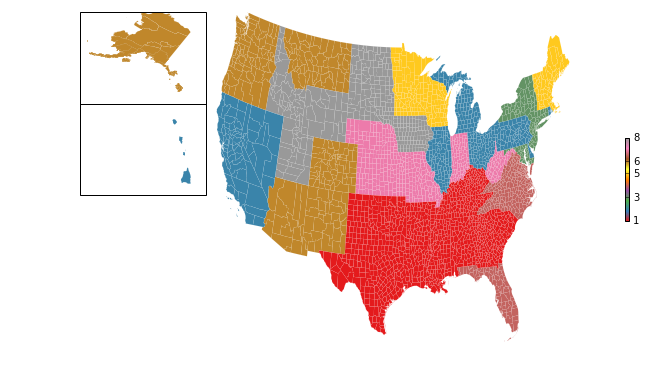

In [49]:
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as sch
import matplotlib.cm as cmx
import matplotlib.colors as colors

max_d = 5
Y = sch.linkage(st_correlations, method='ward')
clusters = fcluster(Y, 3, criterion='distance')

## reorder into the hierarchical clustering ordering, 
## then take the top triangle of this symmetric matrix
forplot = st_correlations.iloc[clusout[3],clusout[2]].copy()
for entry in zip(*tuple(np.where(np.tril(np.ones(forplot.shape))[:,range(forplot.shape[1]-1,-1,-1)]==1))):  
    forplot.iloc[entry[0],entry[1]] = 0
f, ax = plt.subplots(1,figsize=(7,7))
ax.set_aspect('equal')
figures.img_only(ax, f, forplot.rename(index=stid2name, columns=stid2name),
                           'bwr',
                               cmax=.6,cmin=-.6 )

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('top')
ax.xaxis.tick_top()   

## Make colors for blocks of the country, and put those on the diagonal of the cluster plot
cmap = cmx.get_cmap('Set1') #jet') #cubehelix gist_ncar  'gist_ncar' jet
norm = colors.Normalize(vmin=1, vmax=clusters.max()) 
scmap = cmx.ScalarMappable(norm=norm, cmap=cmap)

for (i, stateclus) in enumerate(clusters[clusout[2]]):
    ax.plot(i,50-i,('s' if stateclus%2==1 else 'o'),color=scmap.to_rgba(stateclus),markersize=7,linewidth=0)
import matplotlib.patches as patches

## Make a map of the clusters
clusord = clusters[clusout[2]]
st2clus = {st:clusord[i] for i,st in enumerate(forplot.columns)}
mpr = maps.mplmap2(m, emp, pd.Series(st2clus),scmap, state_level=True)

## Maps of county projections
The four plots below are are Fig 2A, 3A, 4A, 4D, respectively

states? False
states? False
states? False
states? False


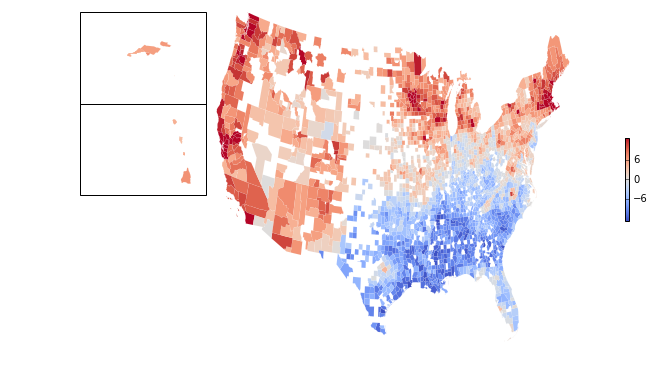

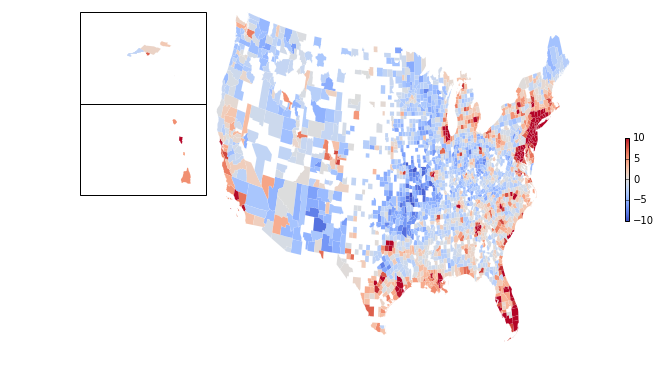

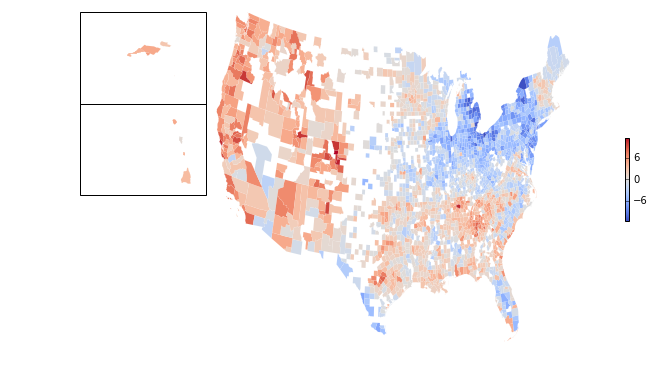

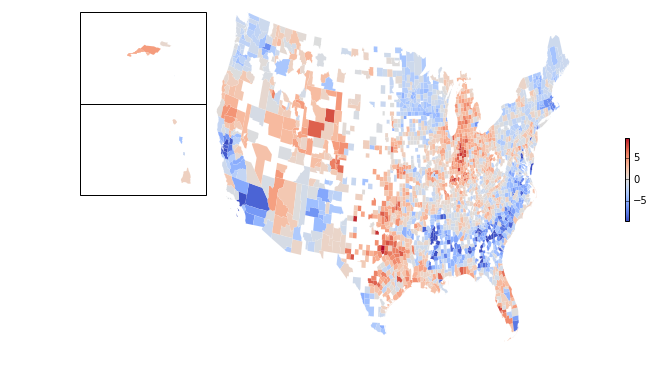

In [32]:
for d in list(pcav['xscores'].columns)[:4]:
    mp = maps.mplmap(m, emp, pcav['xscores'][d]) #,topq=98)
    #mp[0].savefig('svdnorm' + d + '.map.png',bbox_inches='tight',dpi=300,transparent=True)

## Figure 2

states? False


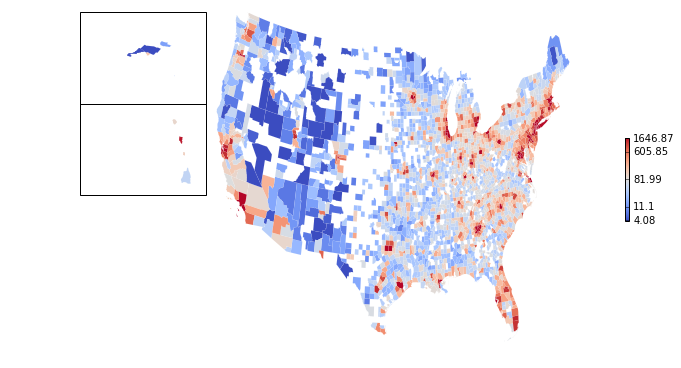

In [52]:
# Figure 2B: density (People per square mile)
x = np.log(demo0['density'])
f= maps.mplmap(m, emp, x - np.mean(x),topq=99)
f[2].set_ticklabels([round(i, 2) for i in np.exp(np.array(f[3]) + np.mean(x))])

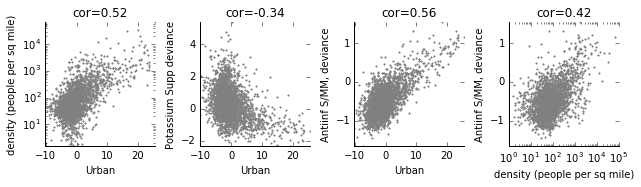

In [67]:
## Figure 2 C, D, E
gonad = {'lab':'Gonadotropins deviance',
         'dat':dev.loc[:,c2d['Gonadotropins']].median(axis=1)}
potass = {'lab':'Potassium Supp deviance',
         'dat':dev['potassium_chloride']}
density = {'lab':'density (people per sq mile)',
           'dat':demo0['density'],
           'log':True } #'Access to exercise opportunities Value'
#ct = fda_nadac.loc[c2d['Antiinf S/MM, Antiinf Loc Misc'],'count']
benzoyl = {'lab':'Antiinf S/MM, deviance',
         'dat':dev.loc[:,c2d['Antiinf S/MM, Antiinf Loc Misc']].median(axis=1)} #dsn['benzoyl_peroxide_clindamycin_phosphate']}
v1 = {'lab':'Urban',
         'dat':pcav['xscores']['V2']}
loc = plt.MaxNLocator(6)
f, ax = plt.subplots(1,4,figsize=(9,2.7),tight_layout=True)
figures.xy(v1, density, ax[0])
figures.xy(v1, potass, ax[1])
figures.xy(v1, benzoyl, ax[2])
figures.xy(density, benzoyl, ax[3])

## Figure 3

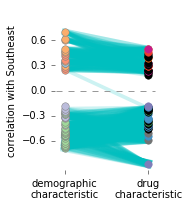

In [243]:
## Figure 3B
(drugcolors, drugcolors2, demcolor, demcolor2,c2ca) = pickle.load(open('data/color_drug_dem.pkl'))
f,a = figures.bipartite_unlabeled('V1',.18,.2,pcav,drugcolors2,demcolor2)
a.set_ylim(-1,1)
a.set_xlim(0,8)
a.set_yticks(np.linspace(-.6,.6,5))
f.set_size_inches(2,3)
a.spines['bottom'].set_visible(False)
a.spines['left'].set_visible(False)
a.set_ylabel('correlation with Southeast')

To create figure 3C, the command below generates files to the directory `circos_files`, which has circos configuration files.  To generate the circos image, you must have circos installed and set up with the paths correctly. Once you generate the input files, then you can run, from the `circos_files` directory:

    circos -conf circos.conf

In [72]:
figures.circos_files('V1',.18,.2,pcav,demcolor,drugcolors,'North/West','Southeast')

dropping eyedrops


states? False


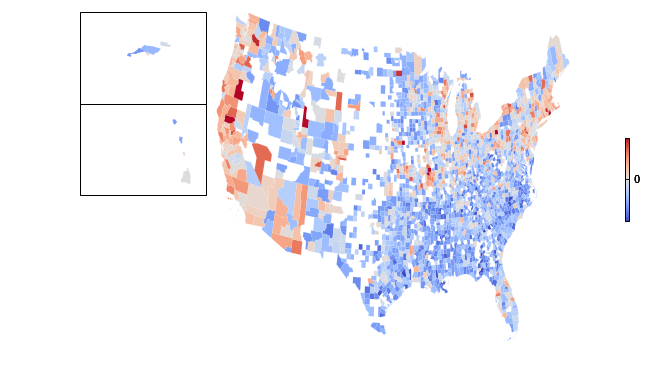

In [68]:
## Fig 3D
f = maps.mplmap(m, emp, 
                dev.loc[:,partition2drug['Psychother,Tranq/Antipsychotic']].median(axis=1),topq=99.8)
#f[0].savefig('V2_antipsychotic_wtdat.png',bbox_inches='tight',dpi=300,transparent=True)

states? False


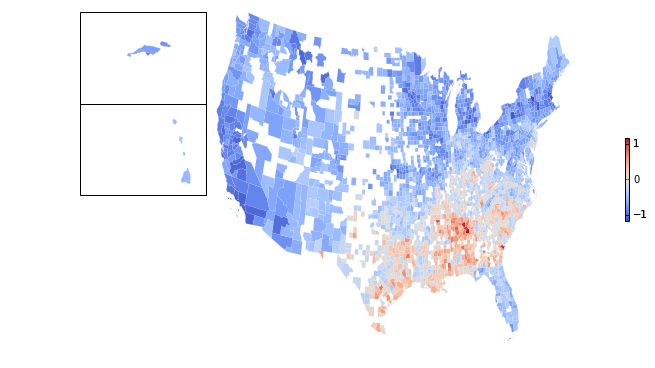

In [59]:
## Fig 3E
f = maps.mplmap(m, emp, 
                dev.loc[:,partition2drug['Antitussives/Cold Comb']].median(axis=1))
#f[0].savefig('V2_antipsychotic_wtdat.png',bbox_inches='tight',dpi=300,transparent=True)

states? False


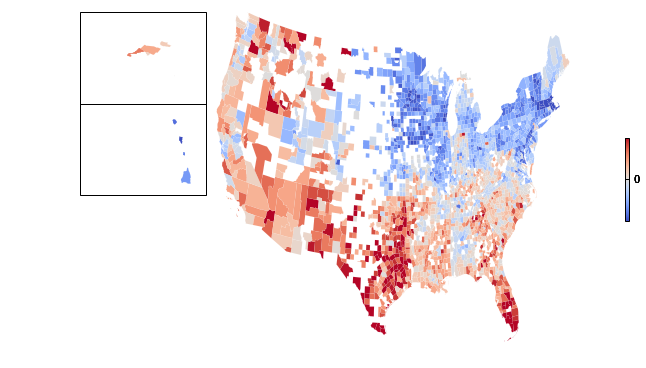

In [61]:
# Figure 4B: Fraction uninsured 
f= maps.mplmap(m, emp, demo0['Uninsured Value']-demo0['Uninsured Value'].mean(),topq=99)

states? False


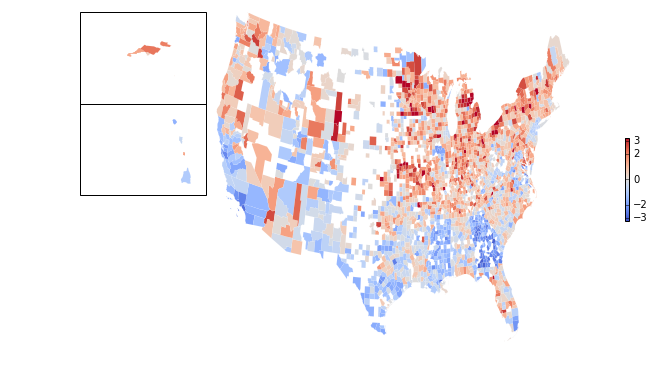

In [62]:
## Fig 4C: Varenicline use
f = maps.mplmap(m, emp, dev['varenicline'])

(-11.827905760436195, 11.827905760436195)


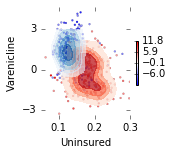

In [74]:
## Fig 4C
f, ax = figures.mycont(demo0['Uninsured Value'], dev['varenicline'], 
               pcav['xscores']['V3'], [.07,.3,-3,3],[.6,1.2,1.6,2.0,3], [1,1.5,2,3,4,5])
ax.set_xlabel('diabetes drugs')
ax.set_ylabel('thyroid replacement')
ax.set_xlabel('Uninsured')
ax.set_ylabel('Varenicline')
ax.set_xlim(.05,.3)
ax.set_xticks(np.linspace(.1,.3,3))

f.set_size_inches(2,2)

(-9.7900544011215409, 9.7900544011215409)


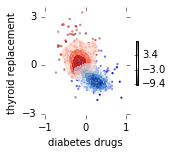

In [76]:
# Fig 4E

def logwtdat(ddo):
    ct = np.log(fda_nadac.loc[ddo,'count'])
    return(dev.loc[:,ddo]*ct/ct.sum()).sum(axis=1)

diab = [c  for c in c2d if 'diab' in c.lower()]
diabdrug = set(chain.from_iterable([c2d[c] for c in diab])) - set(['lancet','lancet_device','lidocaine_hydrochloride'])

diabwt = pd.DataFrame(logwtdat(diabdrug)) #c2d['Antidiabetic Agents, Misc'] | c2d['Antidiabetic Ag, Sulfonylureas']))
thyrwt = pd.DataFrame(logwtdat(c2d['Thy/Antithy, Thyroid/Hormones']))

f, ax = figures.mycont(diabwt[0], thyrwt[0], pcav['xscores']['V4'], [-1,1,-3,3],[.2,.5,.8,1.1], [.3,.6,.8,1,1.2])
ax.set_xlabel('diabetes drugs')
ax.set_ylabel('thyroid replacement')
f.set_size_inches(2,2)

## Figure 5


In [80]:
scperc = {v:[pcav['xscores'][v].sort_values(),
                np.percentile(pcav['xscores'][v],[5,95])] 
          for v in ['V1','V2','V3','V4']}

In [82]:
tomap = scperc['V2'][0].copy()
tomap[:] = 0
tomap.loc[scperc['V2'][0] < scperc['V2'][1][0]] = -1
tomap.loc[scperc['V2'][0] > scperc['V2'][1][1]] = 1

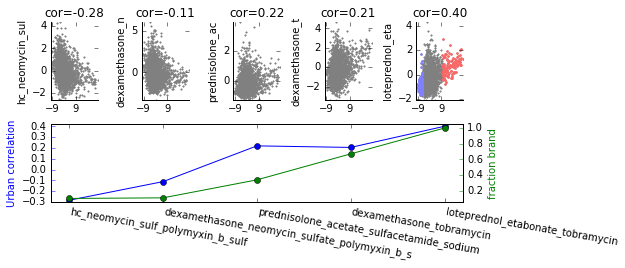

In [85]:
## Figure 5A
f = figures.price_cor_cor(c2d['Antiinfect, Antiinflam EENT'],'V2', pcav, fda_nadac, tomap, dev)

states? False


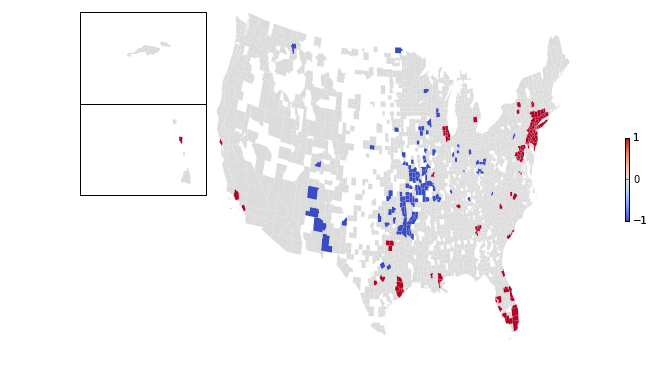

In [87]:
## Figure 5C
mpr = maps.mplmap(m, emp, tomap)

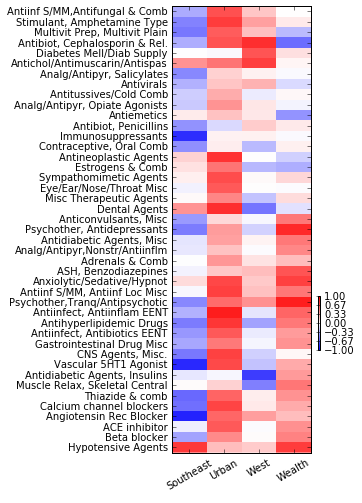

In [106]:
## Figure 5B
import price_correlation
heartc2d = pickle.load(open('data/heartc2d_curated.pkl'))
pricecor = price_correlation.correlations(heartc2d, pcav, fda_nadac,cutndrug=5)
ordering = open('data/rorder.txt').read().strip('\n').split('\n')

f, ax = plt.subplots(1,figsize=(2.5,8))
clustimg.img_only(ax, f, pricecor.loc[ordering,:],'bwr',
                               cmax=1,cmin=-1)
ax.set_xticklabels(['Southeast','Urban','West','Wealth'],rotation=30)


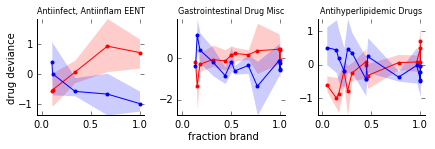

In [110]:
## Figure 5D
scores = pcav['xscores']['V2'].sort_values()
perc = np.percentile(scores,[10,95]) ## super skewed distr -- plt.hist(scores)
f, ax = plt.subplots(1,3,figsize=(6,2),tight_layout=True)
figures.rangeplots(scores, perc,'Antiinfect, Antiinflam EENT', ax[0],c2d, dev, fda_nadac )
#rangeplots(scores, perc,'Antibiot, Cephalosporin & Rel.', ax[1] )
figures.rangeplots(scores, perc,'Antihyperlipidemic Drugs', ax[2],c2d, dev, fda_nadac)
figures.rangeplots(scores, perc,'Gastrointestinal Drug Misc', ax[1],c2d, dev, fda_nadac)
f.text(.5,0,'fraction brand',ha='center')
f.text(0,.5,'drug deviance',va='center',rotation=90)

states? False


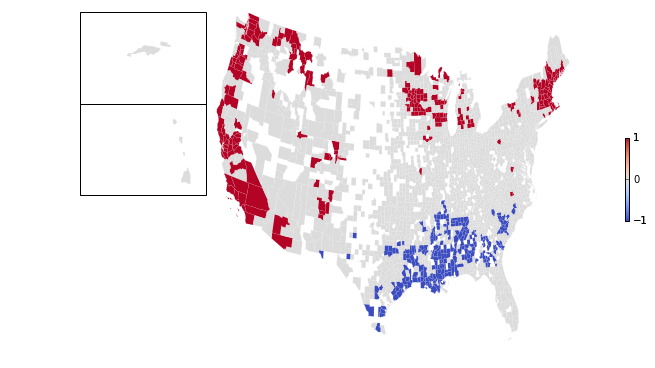

In [113]:
## Figure 5E
scores= pcav['xscores']['V1'].sort_values()
tomap =scores.copy()
perc = np.percentile(tomap,[10,90]) 
tomap[:] = 0
tomap.loc[scores < perc[0]] = -1
tomap.loc[scores > perc[1]] = 1
mpr = maps.mplmap(m, emp, tomap)

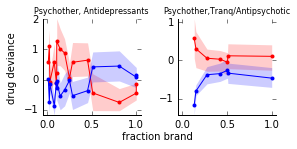

In [116]:
f, ax = plt.subplots(1,2,figsize=(4,2),tight_layout=True)
figures.rangeplots(scores, perc,'Psychother, Antidepressants', ax[0],c2d, dev, fda_nadac )
figures.rangeplots(scores, perc,'Psychother,Tranq/Antipsychotic', ax[1],c2d, dev, fda_nadac)

f.text(.5,0,'fraction brand',ha='center')
f.text(-.02,.5,'drug deviance',va='center',rotation=90)

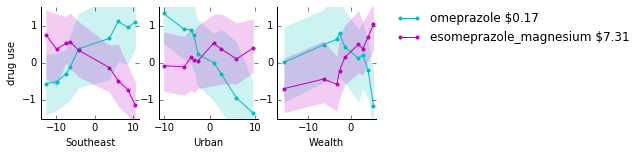

In [121]:
## Figure 5F
component_sel = {'V1':'Southeast','V2':'Urban','V4':'Wealth'}
f, ax = plt.subplots(1,3,figsize=(6,2))
lo = 'omeprazole'
hi = 'esomeprazole_magnesium'
for i, d in enumerate(component_sel.keys()):
    figures.rangePair(pcav['xscores'][d],lo, hi , ax[i],dev)
    ax[i].set_ylim(-1.5,1.5)
    ax[i].set_yticks([-1,0,1])
    ax[i].set_xlabel(component_sel[d])
ax[0].set_ylabel('drug use')
ax[2].legend([lo + ' ${:1.2f}'.format(fda_nadac.loc[lo,'nadac']),
                     hi + ' ${:1.2f}'.format(fda_nadac.loc[hi,'nadac'])],
             bbox_to_anchor=(1.1, 1.05), loc=2,frameon=False)


## Figure 6

### Estimating brand preference per county
Here we assume county use of a drug is only influenced by the drug's therapeutic class (clinical use) and the drug's price. Then, we model the use of a particular drug, in a particular county ($G_{d,c}$) with the linear function:

$$ G_{d,c} \sim BrandPreference_c \cdot Brand_d + ClassPreference_c \cdot Class_d $$
    
Then, we fit this with class preference as a random effect, and get the estimated brand preference coefficient per county.

First we generate the input for the linear model:  the $G_{d,c}$ values for counties (and states):

In [158]:
ds = ((dev-dev.mean(axis=0))/dev.std(axis=0))
ds.index.name = 'place'
ds.loc[:,dev.columns].to_csv('results/county_deviance_norm.txt',sep='\t')

ds = pd.read_pickle('data/drugXstate.predreg.pkl')
ds = ds/np.std(ds)
states = (ds/ds.std(axis=0)).transpose()
states.index.name = 'place'
states.loc[:,dev.columns].to_csv('results/states_deviance_norm.txt',sep='\t')

In [155]:
states.iloc[:5,:5]

fluticasone_furoate  neomycin_sulfate  \
place                                          
30                0.055138         -0.224638   
54                0.234782         -0.264182   
42               -0.091772          0.009580   
48                0.897451         -0.397588   
45               -0.362707         -0.233063   

       betamethasone_dipropionate_calcipotriene  amcinonide  oxybutynin  
place                                                                    
30                                    -0.953343    0.054972    0.258671  
54                                    -0.487282    0.662878   -0.418284  
42                                     0.137832   -0.194908   -0.194225  
48                                    -0.169979   -0.039384   -0.180774  
45                                    -0.124813   -0.002464    0.068113

Then, we create a matrix with relevant drug information: the drug's fraction brand and the therapeutic class of each drug.  Under 100 drugs belong to more than one class. Having more than one class is not compatible with this analysis.  I solved this in two steps:

- Merging drug classes into partitioning (near-partitioning) of the drugs, by merging highly overlapping classes.  This removes 45 classes.
- Randomly assign each drug to one of the classes.  Create 10 of these random assignments, and model county preference with each one.  It turns out not to impact the results too much

In [151]:
drug2partition = {d:set([p for p,v in partition2drug.items() if d in v]) 
                  for d in dev.columns}
d2c = {d:set([p for p,v in c2d.items() if d in v]) 
                  for d in dev.columns}

randp = pd.DataFrame([np.random.choice(list(drug2partition[d]), 10) 
                      if len(drug2partition[d])> 0
                      else 
                      np.random.choice(list(d2c[d]), 10)
                      for d in dev.columns],
             index=dev.columns)
randp['brandred']= fda_nadac.loc[randp.index,'brandred']

randp.loc[dev.columns,:].to_csv('results/brand_drugclass.txt',sep='\t')

# Each of the first 10 columns is a random assignment of a drug to therapeutic class, 
# The 11th column is the drug's fraction brand
randp.iloc[:3,:]

0  \
drug                                                                    
brompheniramine_maleate                        Antitussives/Cold Comb   
amlodipine_besylate_olmesartan_medoxomil     Cardiac, Calcium Channel   
vilazodone_hydrochloride                  Psychother, Antidepressants   

                                                                    1  \
drug                                                                    
brompheniramine_maleate                        Antitussives/Cold Comb   
amlodipine_besylate_olmesartan_medoxomil     Cardiac, Calcium Channel   
vilazodone_hydrochloride                  Psychother, Antidepressants   

                                                                    2  \
drug                                                                    
brompheniramine_maleate                        Antitussives/Cold Comb   
amlodipine_besylate_olmesartan_medoxomil     Cardiac, Calcium Channel   
vilazodone_hydrochloride                  Psychother, Antidepressants   

                                                                    3  \
drug                                                                    
brompheniramine_maleate                        Antitussives/Cold Comb   
amlodipine_besylate_olmesartan_medoxomil     Cardiac, Calcium Channel   
vilazodone_hydrochloride                  Psychother, Antidepressants   

                                                                    4  \
drug                                                                    
brompheniramine_maleate                        Antitussives/Cold Comb   
amlodipine_besylate_olmesartan_medoxomil     Cardiac, Calcium Channel   
vilazodone_hydrochloride                  Psychother, Antidepressants   

                                                                    5  \
drug                                                                    
brompheniramine_maleate                        Antitussives/Cold Comb   
amlodipine_besylate_olmesartan_medoxomil     Cardiac, Calcium Channel   
vilazodone_hydrochloride                  Psychother, Antidepressants   

                                                                    6  \
drug                                                                    
brompheniramine_maleate                        Antitussives/Cold Comb   
amlodipine_besylate_olmesartan_medoxomil     Cardiac, Calcium Channel   
vilazodone_hydrochloride                  Psychother, Antidepressants   

                                                                    7  \
drug                                                                    
brompheniramine_maleate                        Antitussives/Cold Comb   
amlodipine_besylate_olmesartan_medoxomil     Cardiac, Calcium Channel   
vilazodone_hydrochloride                  Psychother, Antidepressants   

                                                                    8  \
drug                                                                    
brompheniramine_maleate                        Antitussives/Cold Comb   
amlodipine_besylate_olmesartan_medoxomil     Cardiac, Calcium Channel   
vilazodone_hydrochloride                  Psychother, Antidepressants   

                                                                    9  \
drug                                                                    
brompheniramine_maleate                        Antitussives/Cold Comb   
amlodipine_besylate_olmesartan_medoxomil     Cardiac, Calcium Channel   
vilazodone_hydrochloride                  Psychother, Antidepressants   

                                          brandred  
drug                                                
brompheniramine_maleate                   0.191589  
amlodipine_besylate_olmesartan_medoxomil  1.000000  
vilazodone_hydrochloride                  1.000000

Then, with R in the `results` directory, and [MCMCglmm](https://cran.r-project.org/package=MCMCglmm) installed, source the R code in "code/price_model.R" and run "run()". This should run the analyses to make these files for the figures below.  

states? False


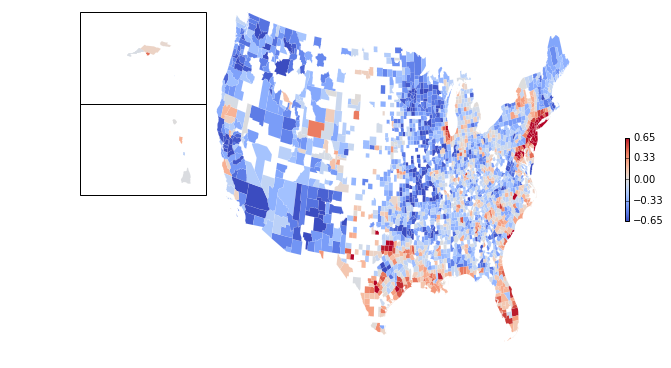

In [181]:
## Figure 6A
countycoef = pd.read_table('results/county_coef.txt',sep='\t',index_col=0,dtype={0:str})
s = countycoef.median(axis=1)
f = maps.mplmap(m, emp, s,topq=98,rounddig=2)

states? True


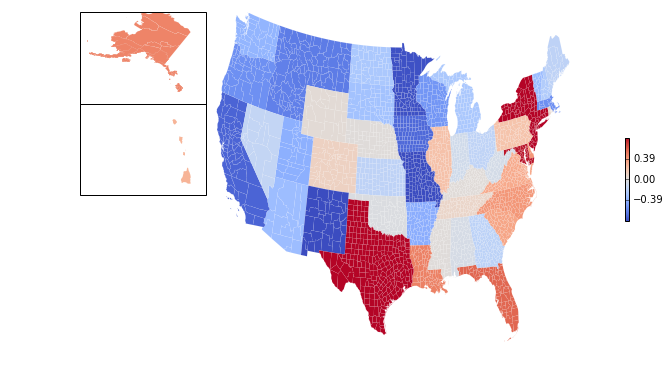

In [178]:
## Figure 6B
statecoef = pd.read_table('results/state_coef.txt',sep='\t',index_col=0,dtype={0:str})
s = statecoef.median(axis=1)
f = maps.mplmap(m, emp, s,topq=98,state_level=True,rounddig=2)

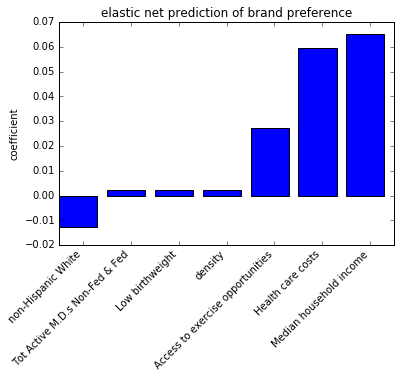

In [183]:
## Figure 6C
from sklearn import linear_model
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(demo0)
demon = scaler.transform(demo0)
demon = pd.DataFrame(demon,index=demo0.index, columns=demo0.columns)

clfp = linear_model.ElasticNetCV(alphas=[.2,.6,.8,1,2],
                                cv=3, 
                                l1_ratio=[.2,.6,.9],max_iter=3000) 
clfp.fit(demon , s)
elr = pd.DataFrame(clfp.coef_.transpose(),index=list(demon.columns) )
f,ax = plt.subplots(1)
elm = elr[0].loc[(elr[0].abs() > 0)].sort_values() #xx.loc[xx.abs() > .01]
ax.bar(range(len(elm)),elm)
ax.set_xticks(np.array(range(len(elm)) )+ .5)
ax.set_xticklabels([figures.mystrip(i) for i in list(elm.index)],rotation=45,ha='right')
ax.set_ylabel('coefficient')
ax.set_title('elastic net prediction of brand preference')


We also estimate the effect of price on how a drug projects, using the projections of *drugs* not counties, as we have been doing. The idea is that This is modeling the following:
$$ Projection_{d} \sim BrandAssociation_d \cdot Brand_d + ClassAssociation_c \cdot Class_d $$

In [251]:
drug_proj = pd.DataFrame(U*Sigma,index= dev.columns,columns = pcav['xscores'].columns)
drug_proj.to_csv('results/drug_projection.txt',sep='\t')

In [257]:
pd.read_table('results/component_price_effect_estimates.txt',sep='\t')

5         50         95
V1  -8.393975  -6.057165  -3.664729
V2  10.969918  12.776879  14.531712
V3  -2.597082  -1.005393   0.418893
V4   4.189111   5.558456   6.898516
V5  -0.613101   0.521697   1.818302
V6  -1.560188  -0.696464   0.166927
V7  -0.373308   0.626188   1.562301
V8  -0.461265   0.462261   1.374727

## Figure 7

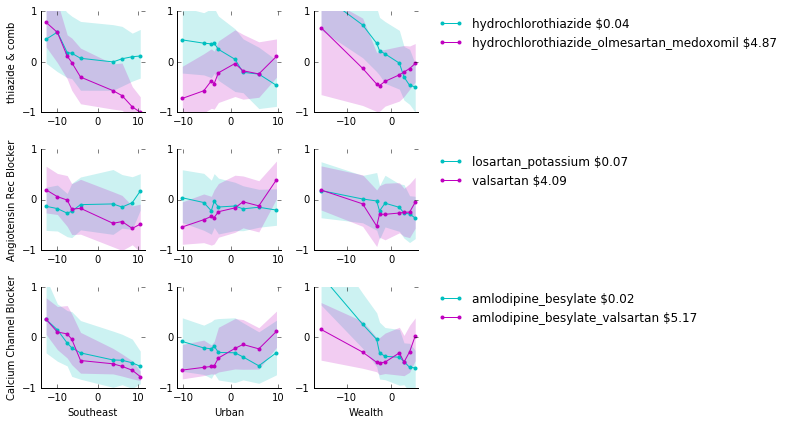

In [185]:
classco = {'Calcium Channel Blocker':['amlodipine_besylate','amlodipine_besylate_valsartan'],
'Angiotensin Rec Blocker':['losartan_potassium','valsartan'], #hydrochlorothiazide_olmesartan_medoxomil'
 'thiazide & comb':['hydrochlorothiazide','hydrochlorothiazide_olmesartan_medoxomil']
}
dimco = {'V1':'Southeast','V2':'Urban','V4':'Wealth'} #,'V3':'West'}
f, ax = plt.subplots(len(classco),len(dimco),figsize=(6,6),tight_layout=True)
xv = {}
for (cname, axi) in zip(*tuple((classco.keys(), list(ax)))):
    lo,hi = classco[cname]
    for (i,v) in enumerate(dimco):
        figures.rangePair(pcav['xscores'][v],lo, hi , axi[i],dev)
        #rangePair(scperc[v][0],lo,hi, axi[i])
        xv[v] = axi[i].set_ylim(-1,1)
    axi[i].legend([lo + ' ${:1.2f}'.format(fda_nadac.loc[lo,'nadac']),
                     hi + ' ${:1.2f}'.format(fda_nadac.loc[hi,'nadac'])],
                  bbox_to_anchor=(1.1, 1.05), loc=2, frameon=False)
    axi[0].set_ylabel(cname)

for (i, v) in enumerate(dimco):
    axi[i].set_xlabel(dimco[v])


# Supplementary figures!

## Supplementary Fig 1, drug similarity

### Supp Figure 1A
This uses the Eand index to see how well the vectors of drug distances, across counties, recover "true labels" of drugs. We consider the labels to be drug therapeutic classes. Rand index is most used in settings with a few classes so the rules of thumb for what is a "good score" are not realistic. We have 147 classes, with overlaps.  To deal with this, we took the following steps

- Merging classes that are similar (overlapping drugs), pretty extremely, to get 75 groups only.  These still have overlaps.  
- Randomly assign a drug to one of the groups it belongs to, for drugs with more than one group.
- Get the distribution of Rand index across these random samplings: green distribution below (this would be expected to be a pretty narrow distribution, since most drugs belong to only one groups). 
- Compare this to a "random" labeling: permuting the class labels, and getting the distribution of Rand index. This is the blue distribution below.

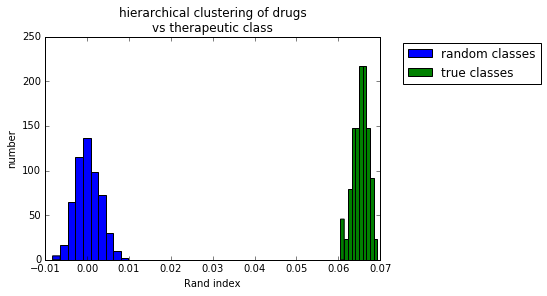

In [200]:
drug2group = pickle.load(open('data/drug_groupings.pkl'))
group2drug = {p:[d for d in drug2group if p in drug2group[d]] 
                  for p in set(chain.from_iterable(drug2group.values()))}    
#groups = partition2drug.keys()
drug2group = {d:v for d,v in drug2group.items() if d in dev.columns}
groups = sorted(set(chain.from_iterable(drug2group.values())))
dnoc = {d:list(d2c[d])[0] + '-' + str(len(c2d[list(d2c[d])[0]])) 
 for d,v in drug2group.items() if len(v) == 0}
 
dsn2 = ((dev-dev.mean(axis=0))/dev.std(axis=0))
drugdo = list(set(dsn2.columns) - set(dnoc.keys()))

from sklearn.cluster import AgglomerativeClustering as hclust
from sklearn.metrics.cluster import adjusted_rand_score
cluspred = hclust(n_clusters = 30).fit_predict(dsn2.loc[:,drugdo].transpose())
# len(partition2drug)
rsc = [adjusted_rand_score([groups.index(np.random.choice(list(drug2group[d]), 1)[0]) for d in drugdo], 
                           np.random.permutation(cluspred)) for i in range(1000)]
tsc = [adjusted_rand_score([groups.index(np.random.choice(list(drug2group[d]), 1)[0]) for d in drugdo], 
                    cluspred) for i in range(100)]

f,ax = plt.subplots(1)
ax.hist(rsc,normed=True)
ax.hist(tsc,normed=True)
ax.legend(['random classes','true classes'],bbox_to_anchor=(1.05,1),loc=2)
ax.set_xlabel('Rand index')
ax.set_ylabel('number')
ax.set_title('hierarchical clustering of drugs\nvs therapeutic class')


### Supp Figure 1B
We run elastic net to predict each thyroid drug, using the all other drugs as predictors. Then we plot the distribution of coefficients

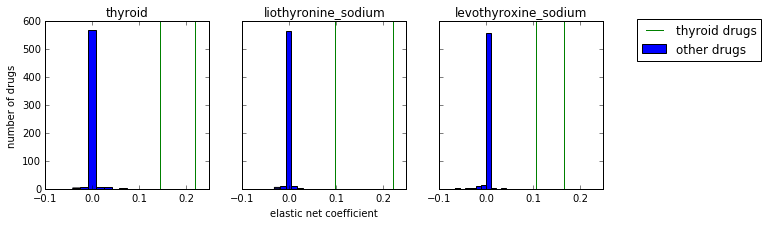

In [205]:
from sklearn import linear_model
thyr = list(c2d['Thy/Antithy, Thyroid/Hormones'])

drugdo = thyr
elres = pd.DataFrame(float('nan'), index = dev.columns, columns = drugdo)
for todo in drugdo: # = 'liothyronine_sodium'
    doon = dev.drop(todo,axis=1)
    el = linear_model.ElasticNet(fit_intercept=True, alpha=.1, 
                                   l1_ratio=.5).fit(doon, dsn2[todo])
    elres.loc[doon.columns,todo] = el.coef_
thyr = list(c2d['Thy/Antithy, Thyroid/Hormones'])

f, ax= plt.subplots(1,len(thyr),figsize=(10,3),sharey=True,sharex=True)
isthyr = elres.index.isin(thyr)
for i in range(len(thyr)):
    ax[i].hist(
              list(elres.loc[~isthyr, thyr[i]]))
    y = False
    for j in list(elres.loc[isthyr & ~pd.isnull(elres[thyr[i]]),thyr[i]]):
        ax[i].plot([j,j],ax[i].get_ylim(),color='g',label="_nolegend_" if y else "thyroid drugs")
        y =True
    ax[i].set_title(thyr[i])
    ax[i].set_xticks(np.arange(-.1,.3,.1))
ax[0].set_xlim(-.1,.25)
ax[1].set_xlabel('elastic net coefficient')
ax[0].set_ylabel('number of drugs')
ax[2].legend(['thyroid drugs','other drugs'],bbox_to_anchor=(2, 1.05))
    

0


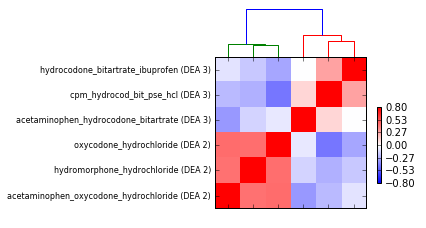

In [206]:
ops = ['hydromorphone_hydrochloride','oxycodone_hydrochloride',
                                      'acetaminophen_oxycodone_hydrochloride', 
       'cpm_hydrocod_bit_pse_hcl','hydrocodone_bitartrate_ibuprofen',
      'acetaminophen_hydrocodone_bitartrate',] 
opcor = dev.loc[:,ops].corr(method='spearman')
ren = {c:c+ ' (DEA ' + fda_nadac.loc[c,'dea']+')' for c in ops}
f,ax,xix,yix = clustimg.clust2way(opcor.rename(columns=ren, index=ren),'bwr',
                               cmax=.8,cmin=-.8,cluster_columns=True,no_row_dendrogram=True)
ax.set_xticklabels([])
f.set_size_inches(3.5,3.5)


states? False


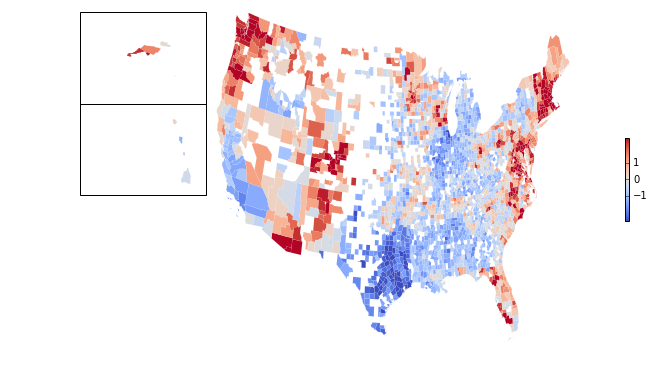

In [208]:
## Supp Fig 2B
sched2oxy = ['hydromorphone_hydrochloride','oxycodone_hydrochloride',
                                      'acetaminophen_oxycodone_hydrochloride']
f = maps.mplmap(m, emp, (dev.loc[:,sched2oxy].median(axis=1)),topq=99)

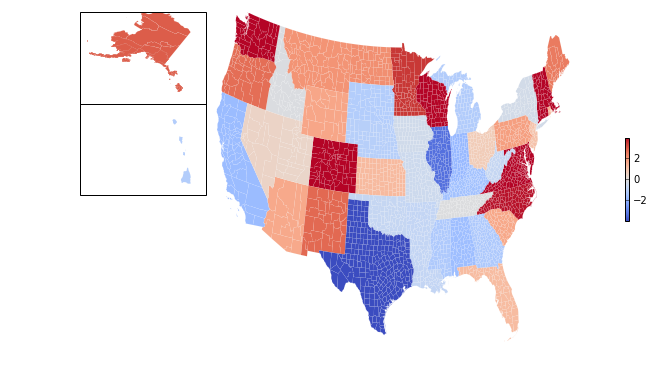

In [211]:
## Supp Fig 2C
statedev = pd.read_pickle('data/drugXstate.predreg.pkl')
statedev = statedev/np.std(statedev)
f = maps.mplmap(m, emp, (ds.transpose().loc[:,sched2oxy].median(axis=1)),state_level=True,topq=99)

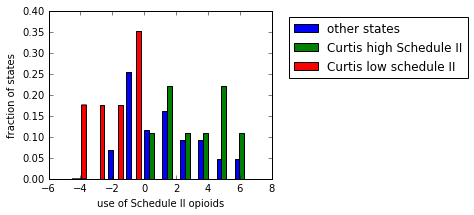

In [212]:
statedev=ds
hi  = [i for i,v in stid2name.items() if v in ['AK','AZ','DE','MD','MA','NH','SC','TN']]
lo  = [i for i,v in stid2name.items() if v in ['CA','TX','IL','MI','NY']]
oxys = states.loc[:,sched2oxy].median(axis=1) #*fda_nadac.loc[ddo,'count']/fda_nadac.loc[ddo,'count'].sum()).sum(axis=1)

f,ax=plt.subplots(1,figsize=(4,3))
ax.hist([oxys[~oxys.index.isin(hi + lo)], oxys[hi],oxys[lo]],normed=True)
ax.legend(['other states','Curtis high Schedule II','Curtis low schedule II'],bbox_to_anchor=(1.05,1),loc=2)
ax.set_xlabel('use of Schedule II opioids')
ax.set_ylabel('fraction of states')


In [216]:
phi = stats.ranksums(oxys[~oxys.index.isin(hi )], oxys[hi]).pvalue
plo = stats.ranksums(oxys[~oxys.index.isin(lo )], oxys[lo]).pvalue
print 'Consistency with Curtis results:'
print '- Finding Curtis low Schedule II oxycodone use to be lower than other states {:1.2e}'.format(plo)
print '- Finding Curtis high Schedule II oxycodone use to be higher than other states {:1.2e}'.format(phi)

Consistency with Curtis results:
- Finding Curtis low Schedule II oxycodone use to be lower than other states 2.62e-03
- Finding Curtis high Schedule II oxycodone use to be higher than other states 8.25e-03


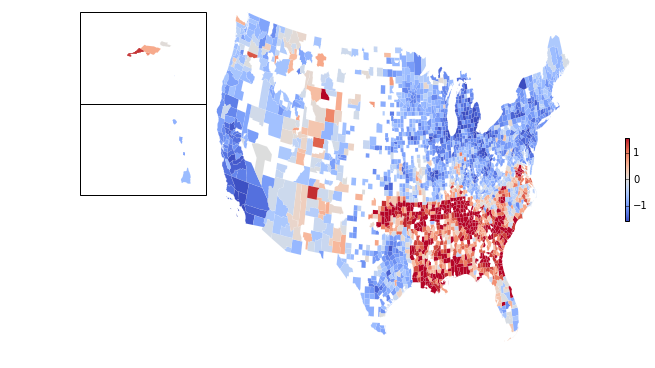

In [209]:
## Supp Fig 2E
f = maps.mplmap(m, emp, (dev.loc[:,[u'meperidine_hcl_promethazine_hcl','meperidine_hydrochloride']].mean(axis=1)),topq=99)

## Supplementary Figure 3

0


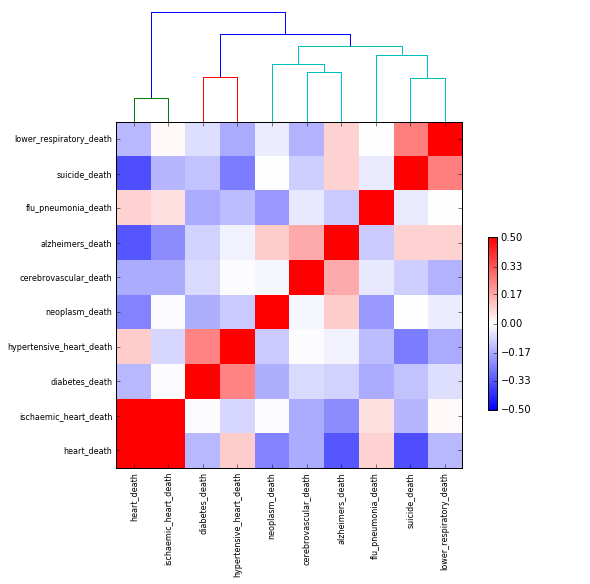

In [219]:
## Supp Fig 3A
deathdat = demo0.loc[:,demo0.columns.str.endswith('death')]
f = clustimg.clust2way(deathdat.corr(),'bwr',cmax=.5,cmin=-.5,no_row_dendrogram=True) 

### Supplementary Figure 3B
We would ideally expect death rate from a disease such as diabetes, and drug use for diabetes, to correspond to the underlying rate of diseases in each county

To test this, we take an approach similar to supplmentary figure 1B. We do elastic net regression to predict death rates in each county based on drug use in each county. Then, we test whether the coefficients are particularly high, or particularly low, for some chosen drug sets.

First, do the regression:

In [229]:
test = {}
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(dev)
dsnN = scaler.transform(dev)

for d in deathdat.columns:
    y = deathdat[d]*1000 
    sel = ~pd.isnull(y)
    from sklearn import linear_model
    el = linear_model.ElasticNetCV(fit_intercept=True, alphas=np.logspace(-2,1,5), 
                                   l1_ratio=[.1,.2,.6,.9],cv=5).fit(dsnN[np.where(sel)[0],:],
                                                                    y[sel])
    x = pd.DataFrame(el.coef_,index=dev.columns)
    x.sort_values(0,ascending=False)[:5]
    test[d] = x
    print d, el.l1_ratio_, el.alpha_
elr = pd.concat(test,axis=1).transpose().reset_index(1,drop=True).transpose()    

heart_death 0.1 1.77827941004
cerebrovascular_death 0.6 0.316227766017
flu_pneumonia_death 0.2 0.316227766017
diabetes_death 0.6 0.316227766017
suicide_death 0.1 0.316227766017
alzheimers_death 0.1 1.77827941004
neoplasm_death 0.9 0.316227766017
hypertensive_heart_death 0.6 0.316227766017


/Users/melamed/bin/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ischaemic_heart_death 0.1 1.77827941004
lower_respiratory_death 0.2 0.316227766017


Then, create the drug sets, and do the tests of the coefficients for each drug set:

In [231]:
heartc2d = pd.read_pickle('data/cardiovascular_drugs_curated.pkl')
diabetes_classes = [p for p in c2d if 'diabet' in p.lower()]
diabetes_drugs = (set(chain.from_iterable([c2d[p] for p in diabetes_classes])) - 
                  set(['lidocaine_hydrochloride','lancet','lancet_device']) )& set(dev.columns)
ddo = {d:v for d,v in heartc2d.items() if d.endswith('DIS')}
ddo.update({'heart':list(set(chain.from_iterable(heartc2d.values()))),
      'antidiabetics':diabetes_drugs,
        'COPD':set(['ipratropium_bromide','tiotropium_bromide']) | c2d['Sympathomimetic Agents'],
        'Antidepressants':c2d['Psychother, Antidepressants']   
           })

drug_death_en = pd.DataFrame(0,index=deathdat.columns,
                             columns=pd.MultiIndex.from_product([ddo.keys(),['stat','p']],names=['drugs','st']))
for cname, drugs in ddo.items():
    for death in test:
        #print death, 
        r = stats.ranksums(elr.loc[drugs,death], elr.drop(drugs,axis=0).loc[:,death])
        drug_death_en.loc[death, cname] = [r.statistic, r.pvalue]
                             

Figure below shows whether each drug set has significantly high or low coefficients for predicting a cause of death.  The color scheme corresponds to p-values of the rank-sum test.

0


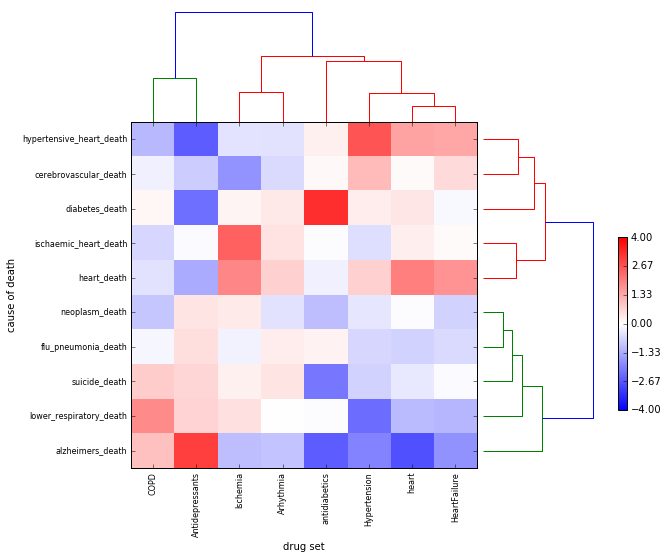

In [233]:
ren = {s:s.replace(':DIS','') for s in drug_death_en.columns.levels[0]}
f = clustimg.clust2way((-1*np.log10(drug_death_en.xs('p',axis=1,level=1))*np.sign(drug_death_en.xs('stat',axis=1,level=1))).rename(columns=ren),
                           'bwr',cmax=4,cmin=-4)
f[1].set_xlabel('drug set')
f[1].set_ylabel('cause of death')

## Supplementary figure 4
Doing SVD on subsets of the data to estimate the variation/stability using the dot product.

In [237]:
v1s = pd.DataFrame(0,index=demo0.index, 
                   columns=pd.MultiIndex.from_product((c2d.keys(),range(4)),
                                                      names=['class','dim']))
for c in c2d:
    Uc, Sigma, Vc = randomized_svd(dsn2.drop(c2d[c],axis=1).transpose(),
                                      n_components=8,
                                            n_iter=7,
                                            random_state=42)
    
    #s, u, sig, v = cca_viz.do_svd(dsnCENTER.loc[demo0.index,:].drop(c2d[c],axis=1))
    v1s[c]= Vc[:4,:].transpose()
    
states = set(demo0.index.str.slice(0,2))    
u1s = pd.DataFrame(0,index=dsn2.columns, 
                   columns=pd.MultiIndex.from_product((states,range(4)),
                                                      names=['class','dim']))
for st in states:
    Uc, Sigma, Vc = randomized_svd(dsn2.loc[~dsn2.index.str.startswith(st),:].transpose(),
                                      n_components=8,
                                            n_iter=7,
                                            random_state=42)    
    u1s[st]= Uc[:,:4]

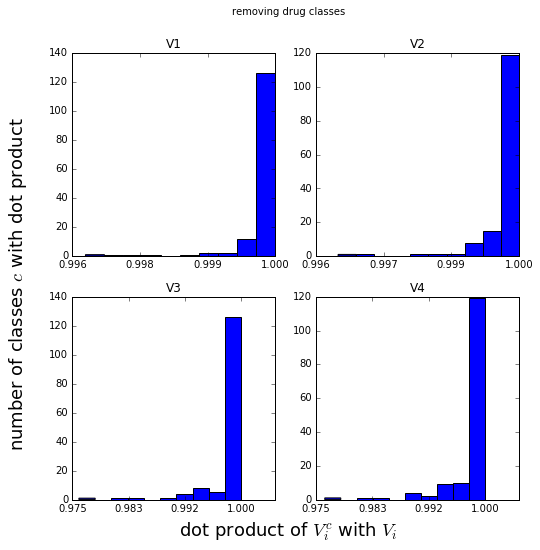

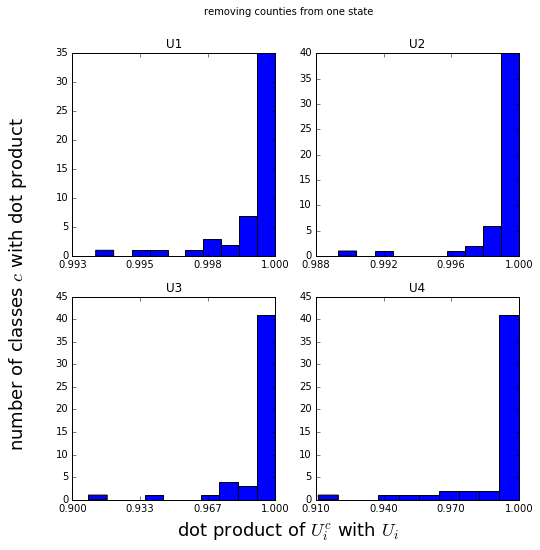

In [241]:
f, ax = plt.subplots(2,2,figsize=(8,8)) #,sharex=True, sharey=True)
ax = list(chain.from_iterable(ax))
for i in range(4):
    ax[i].hist(v1s.xs(i,axis=1,level='dim').apply(lambda x: VT[i,:].dot(x),axis=0).abs())
    ticky = np.linspace(ax[i].get_xlim()[0],1,4)
    ax[i].set_xticks(ticky)
    ax[i].set_xticklabels(['{:1.3f}'.format(j) for j in ticky])
    ax[i].set_title('V' + str(int(i + 1)))
f.text(0.5, 0.05,'dot product of $ V_i^c $ with $V_i$',
         ha='center',va='bottom',fontsize=18)
f.text(0.05,0.5, 'number of classes $c$ with dot product',
         va='center',ha='right',fontsize=18,rotation=90)
f.suptitle('removing drug classes')
f, ax = plt.subplots(2,2,figsize=(8,8)) #,sharex=True, sharey=True)
ax = list(chain.from_iterable(ax))
for i in range(4):
    ax[i].hist(u1s.xs(i,axis=1,level='dim').apply(lambda x: U[:,i].dot(x),axis=0).abs())
    ticky = np.linspace(ax[i].get_xlim()[0],1,4)
    ax[i].set_xticks(ticky)
    ax[i].set_xticklabels(['{:1.3f}'.format(j) for j in ticky])
    ax[i].set_title('U' + str(int(i + 1)))
f.text(0.5, 0.05,'dot product of $ U_i^c $ with $U_i$',
         ha='center',va='bottom',fontsize=18)
f.text(0.05,0.5, 'number of classes $c$ with dot product',
         va='center',ha='right',fontsize=18,rotation=90)

f.suptitle('removing counties from one state')

## Supplementary Fig 5
Clustering of demographics.

In [ ]:
f,ax,xix,yix = clustimg.clust2way(demo0.corr(method='spearman'),'bwr',
                               cmax=.8,cmin=-.8,cluster_columns=True,
                                  no_row_dendrogram=True,hide_top_axis=False)

0


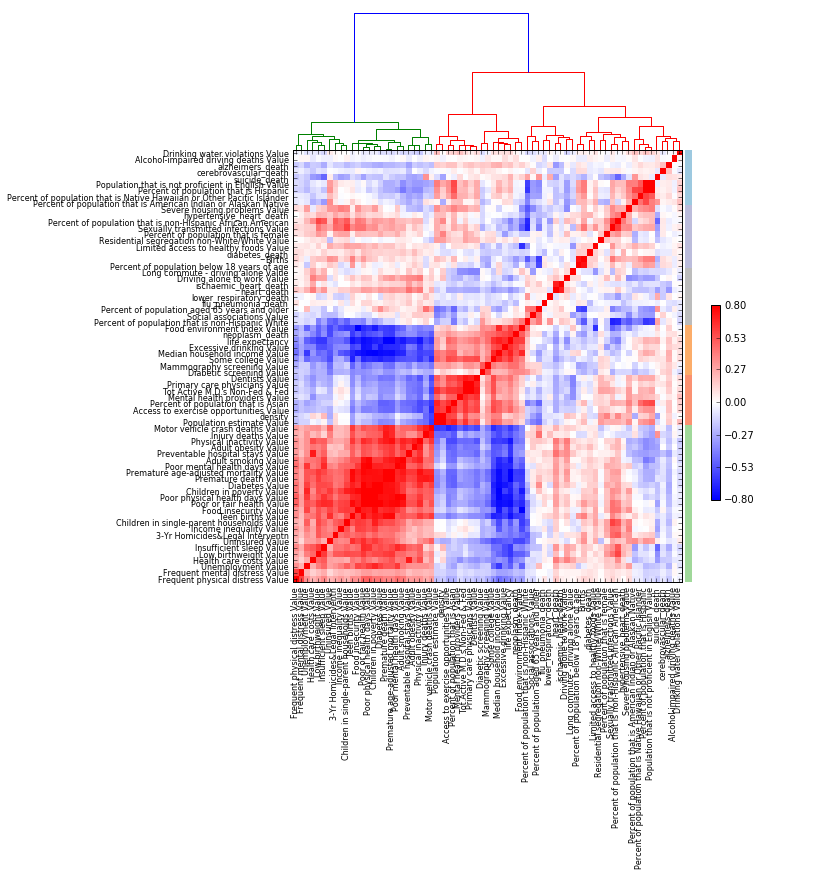

In [246]:

from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as sch
max_d = 5
Y = sch.linkage(demo0.corr(method='spearman'), method='ward')
clusters = fcluster(Y, max_d, criterion='distance') 
colors = [('l' + c if c !='yellow' else 'd' + c) for c in 
          ['green','red','orange','grey','purple','blue']]


f,ax,xix,yix = clustimg.clust2way(demo0.corr(method='spearman'),'bwr',
                               cmax=.8,cmin=-.8,cluster_columns=True,no_row_dendrogram=True)
bbox = ax.get_position()
axb = f.add_axes([.55,bbox.ymin,0.3,bbox.height])

from matplotlib import colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list(name='clus', 
                                      colors=[c2ca[colors[i-1]] for i in sorted(set(clusters))],
                                                 N=len(set(clusters)))

axb.imshow(clusters[yix].reshape(len(clusters),-1),cmap=cmap,vmin=1, vmax=max(clusters),interpolation='nearest')
axb.set_yticks([])    
axb.set_xticks([])
axb.set_axis_off()
f.set_size_inches(9,10)

## Supp Figure Thyroid

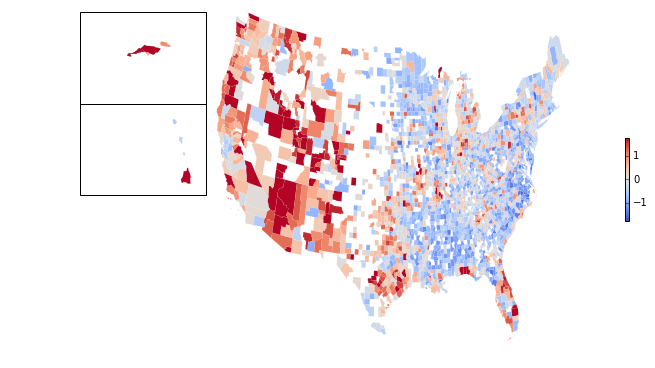

In [247]:
ft = maps.mplmap(m, emp, dsn2.loc[:,thyr].median(axis=1))


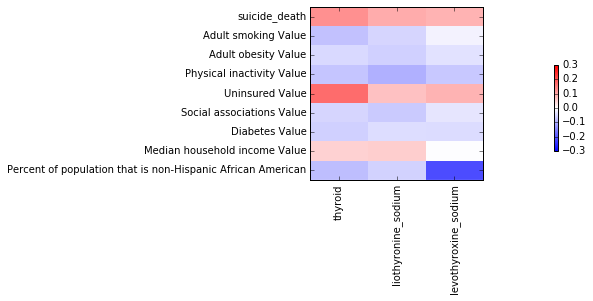

In [250]:
clfp = linear_model.MultiTaskElasticNetCV(alphas=[.2,.6,.8,1,2],
                                          cv=3, 
                                          l1_ratio=[.2,.6,.9],max_iter=3000) 
thyr = c2d['Thy/Antithy, Thyroid/Hormones']
clfp.fit(demon,dsn2.loc[demon.index,thyr] )
xx = pd.DataFrame(clfp.coef_.transpose(),index=demon.columns,columns=thyr)
fig = plt.figure()
axmatrix = fig.add_axes([0.09,.1,.6,.6]) #imgbottom,imgwidth,imgheight])
cut = .3
clustimg.img_only(axmatrix, fig,xx.loc[(xx.abs()>.05).sum(axis=1)>0,:],'bwr',cut,-1*cut)
fig.set_size_inches(4,4)
#f = viz_unaligned(xx.loc[(xx.abs()>10**-2).sum(axis=1)>0,:],.3)

## Preparing data for the web app

In [34]:
forb = {}
for k,i in pcav.items():
    if i.shape[1] == 8:
        forb[k] = i.iloc[:,:4].rename(columns={'V1':'Southeast','V2':'Urban',
                                               'V4':'Wealth','V3':'West'})
    else:
        forb[k] = i
        
f = open('app/data/pca_results_bokeh.pkl','w')
pickle.dump(forb, f)
f.close()

partitiondat = pd.DataFrame(0,index=demo0.index, columns=partition2drug.keys())
for p,v in partition2drug.items():
    partitiondat[p] = dev.loc[:,v].median(axis=1)
partitiondat.to_pickle('app/data/partition_county.pkl')